In [2]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import random
import pandas as pd
import scipy.special as sc
import scipy.integrate as integrate
from scipy.stats import uniform
from scipy.stats import norm
from statsmodels.stats.power import TTestIndPower
from scipy.stats import gaussian_kde
from arch import arch_model
from random import gauss
from scipy.special import gamma
from scipy.stats import binom


In [3]:
SPX = pd.read_csv("SPX.csv", parse_dates=['Date'], index_col='Date')
SPX_train = SPX.loc['2020-01-02':'2022-12-30', 'Adj Close']
SPX_train_returns = SPX_train.pct_change().dropna()*100

SPX_test = SPX.loc['2023-01-03':'2023-12-29','Adj Close']
SPX_test_returns = SPX_test.pct_change().dropna()*100

# Parametric VaR and ES:

In [4]:
def VaR(alpha = 0.975, sigma2 = 1, mu = 0, shift = 0, scale=1, df=None, type='Normal' , Norm = False):
    if Norm == False:
        if type == 'Normal':
            VaR = mu+np.sqrt(sigma2)*norm.ppf(1-alpha)

        elif type == 't':
            VaR = t.ppf(1-alpha, df, loc=shift, scale = scale)
    elif Norm == True:
        if type == 'Normal':
            VaR = norm.ppf(1-alpha)

        elif type == 't':
            VaR = np.sqrt((df-2)/df)*t.ppf(1-alpha, df, loc=shift, scale = scale)
    return -VaR

def ES(alpha = 0.975, sigma2 = 1, mu = 0, shift = 0, scale = 1, df=None, type='Normal' , Norm = False):
    if Norm == False:
        if type == 'Normal':
            ES = (mu-np.sqrt(sigma2)/(1-alpha)*norm.pdf(norm.ppf(1-alpha)))*scale+shift
        
        elif type == 't':
            x = t.ppf(1-alpha, df)
            ES = -(t.pdf(x, df)/(1-alpha)*(df+x**2)/(df-1))*scale+shift
    
    elif Norm == True:
        if type == 'Normal':
            ES = 1/(1-alpha)*norm.pdf(norm.ppf(1-alpha))*scale+shift
        
        elif type == 't':
            x = t.ppf(1-alpha, df)
            ES = np.sqrt((df-2)/df)*(t.pdf(x, df)/(1-alpha)*(df+x**2)/(df-1))*scale+shift
    
    return ES

# Adj. closing prices and returns:

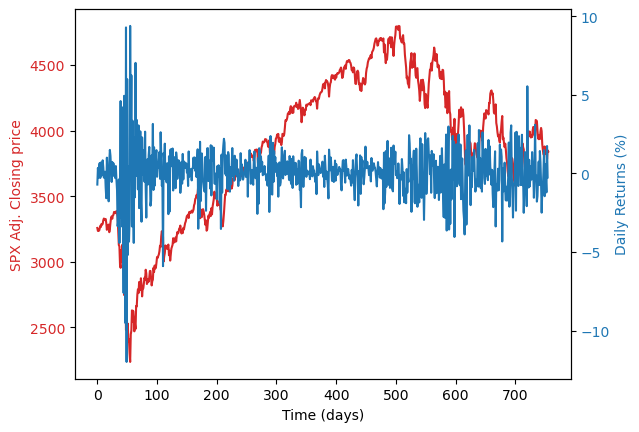

In [5]:
fig, ax1 = plt.subplots()

# Plotting adj closing prices on primary y-axis
color = 'tab:red'
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('SPX Adj. Closing price', color=color)
ax1.plot(range(len(SPX_train)), SPX_train, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Daily Returns (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(SPX_train[1:])), SPX_train_returns, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Show plot
plt.show()

# Model Summary:

# P_t: GARCH(1,1):

In [20]:
garch_train = arch_model(SPX_train_returns.values, mean = 'constant', vol='garch', p=1, q=1, dist = 't')
garch_train_fitted = garch_train.fit(disp='off')
garch_train_forecast = garch_train_fitted.forecast(horizon=249, reindex=False, start = len(SPX_train_returns)-1, method='simulation', simulations=1)
var_forecast_garch_train = garch_train_forecast.variance.values[-1]
garch_train_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1209.96
Distribution:      Standardized Student's t   AIC:                           2429.92
Method:                  Maximum Likelihood   BIC:                           2453.05
                                              No. Observations:                  755
Date:                      Thu, Jun 06 2024   Df Residuals:                      754
Time:                              10:48:51   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1177  3.302e-02      3.563  3.666e-04 [5.293e-02,  0.182]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0480  2.166e-02      2.214  2.680e-02 [5.511e-03,9.041e-02]
alpha[1]       0.2091  4.802e-02      4.353  1.341e-05     [  0.115,  0.303]
beta[1]        0.7904  4.088e-02     19.333  2.841e-83     [  0.710,  0.871]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.5377      1.474      4.435  9.212e-06 [  3.648,  9.427]
========================================================================

Covariance estimator: robust
"""

# P_t: EGARCH(1,1):

In [21]:
garch_train = arch_model(SPX_train_returns.values, mean = 'constant', vol='egarch', p=1, q=1, o=1, dist = 't')
garch_train_fitted = garch_train.fit(disp='off')
garch_train_forecast = garch_train_fitted.forecast(horizon=249, reindex=False, start = len(SPX_train_returns)-1, method='simulation', simulations=1)
var_forecast_garch_train = garch_train_forecast.variance.values[-1]
garch_train_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -1199.81
Distribution:      Standardized Student's t   AIC:                           2411.63
Method:                  Maximum Likelihood   BIC:                           2439.39
                                              No. Observations:                  755
Date:                      Thu, Jun 06 2024   Df Residuals:                      754
Time:                              10:48:54   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0751  3.341e-02      2.249  2.450e-02 [9.664e-03,  0.141]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0113  1.567e-02      0.721      0.471 [-1.942e-02,4.201e-02]
alpha[1]       0.2079  9.000e-02      2.310  2.087e-02    [3.153e-02,  0.384]
gamma[1]      -0.1714  2.577e-02     -6.652  2.899e-11      [ -0.222, -0.121]
beta[1]        0.9712  1.361e-02     71.379      0.000      [  0.945,  0.998]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             6.1928      1.375      4.503  6.694e-06 [  3.497,  8.888]
========================================================================

Covariance estimator: robust
"""

# F_t: GARCH(1,1):

In [22]:
garch_test = arch_model(SPX_test_returns.values, mean = 'constant', vol='GARCH', p=1, q=1, dist = 't')
garch_test_fitted = garch_test.fit(disp='off')
garch_test_forecast = garch_test_fitted.forecast(horizon=1, reindex=False)
variance_test = garch_test_fitted.conditional_volatility
garch_test_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -300.305
Distribution:      Standardized Student's t   AIC:                           610.609
Method:                  Maximum Likelihood   BIC:                           628.197
                                              No. Observations:                  249
Date:                      Thu, Jun 06 2024   Df Residuals:                      248
Time:                              10:48:56   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0900  5.039e-02      1.786  7.418e-02 [-8.790e-03,  0.189]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.0420e-03  5.022e-03      1.601      0.109 [-1.801e-03,1.788e-02]
alpha[1]   2.9069e-17  1.467e-02  1.982e-15      1.000 [-2.875e-02,2.875e-02]
beta[1]        0.9842  1.921e-02     51.246      0.000      [  0.947,  1.022]
                                Distribution                                
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
nu           351.8638     99.367      3.541  3.985e-04 [1.571e+02,5.466e+02]
============================================================================

Covariance estimator: robust
"""

# F_t: EGARCH(1,1):

In [23]:
garch_test = arch_model(SPX_test_returns.values, mean = 'constant', vol='eGARCH', p=1, q=1, o=1, dist = 't')
garch_test_fitted = garch_test.fit(disp='off')
garch_test_forecast = garch_test_fitted.forecast(horizon=1, reindex=False)
variance_test = garch_test_fitted.conditional_volatility
garch_test_fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -293.349
Distribution:      Standardized Student's t   AIC:                           598.698
Method:                  Maximum Likelihood   BIC:                           619.802
                                              No. Observations:                  249
Date:                      Thu, Jun 06 2024   Df Residuals:                      248
Time:                              10:48:59   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0815  3.433e-04    237.407      0.000 [8.083e-02,8.217e-02]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega      1.3304e-03  6.170e-09  2.156e+05      0.000   [1.330e-03,1.330e-03]
alpha[1]      -0.0964  6.299e-04   -153.082      0.000 [-9.766e-02,-9.519e-02]
gamma[1]      -0.0343  9.960e-04    -34.474 1.973e-260 [-3.629e-02,-3.238e-02]
beta[1]        0.9981  5.554e-08  1.797e+07      0.000       [  0.998,  0.998]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu            39.7701      5.403      7.360  1.837e-13 [ 29.180, 50.361]
========================================================================

Covariance estimator: robust
"""

# Example of P_t: GARCH(1,1) og F_t: GARCH(1,1):

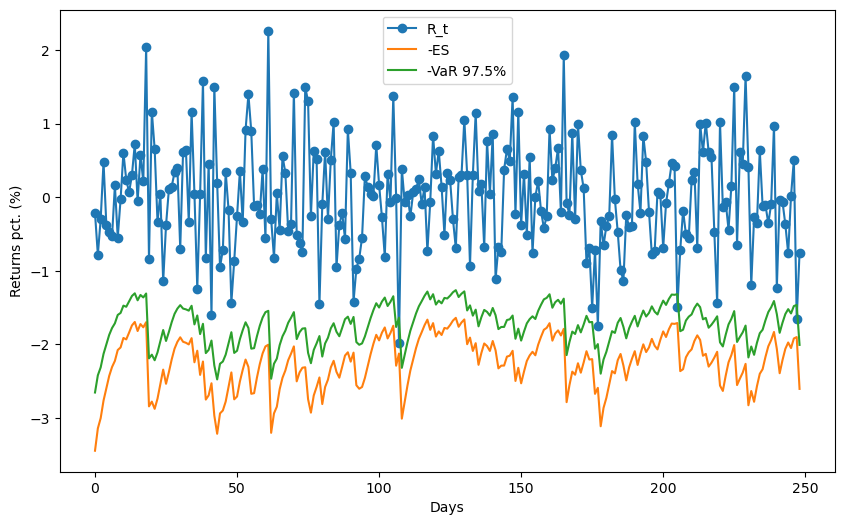

Instances where R_t + VaR < 0: 3


In [25]:
# Fit GARCH(1,1) model to training data
H_1 = arch_model(SPX_test_returns.values, mean='Zero', vol='garch', p=1, q=1, dist='t')
H_1_fitted = H_1.fit(disp='off')

# Forecast using the fitted model
H_1_forecast = H_1_fitted.forecast(horizon=len(SPX_test_returns), reindex=False, start=len(SPX_test_returns)-1, method='simulation', simulations=1)
H_1_var = H_1_forecast.variance.values[-1]
R_t = H_1_forecast.simulations.values[0][0]

# Fit GARCH(1,1) model to training data under null hypothesis
H_0 = arch_model(SPX_train_returns.values, mean='Zero', vol='garch', p=1, q=1, dist='t')
H_0_fitted = H_0.fit(disp='off')
H_0_var = [H_0_fitted.conditional_volatility[-1]**2]
dfnull = H_0_fitted.params['nu']

# Update H_0_var with the simulated returns
for i in range(len(R_t)-1):
    variance = H_0_fitted.params['omega'] + H_0_fitted.params['alpha[1]'] * R_t[i]**2 + H_0_fitted.params['beta[1]'] * H_0_var[i]
    H_0_var.append(variance)

#absEZ_t = (2 / np.sqrt(np.pi)) * (gamma((dfnull + 1) / 2) / gamma(dfnull / 2)) * np.sqrt((dfnull - 2)) / (dfnull - 1)
#for i in range(len(R_t)-1):
    #variance = (
        #H_0_fitted.params['omega'] +
        #H_0_fitted.params['alpha[1]'] * (np.abs(R_t[i]) / np.sqrt(H_0_var[i]) - absEZ_t) +
        #H_0_fitted.params['beta[1]'] * np.log(H_0_var[i])
    #)
    #H_0_var.append(np.exp(variance))

# Calculate VaR and ES
var = VaR(alpha=0.975, df=dfnull, type='t', Norm=True) * np.array(np.sqrt(H_0_var))
es = ES(alpha=0.975, df=dfnull, type='t', Norm=True) * np.array(np.sqrt(H_0_var))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(SPX_test_returns)), R_t, label='R_t', marker='o')  # Simulated returns
plt.plot(range(len(SPX_test_returns)), -es, label='-ES') 
plt.plot(range(len(SPX_test_returns)), -var, label='-VaR 97.5%')
plt.xlabel('Days')
plt.ylabel('Returns pct. (%)')
plt.legend()
plt.show()

# Counting instances where R_t falls below -VaR
instances_below_var = np.sum(R_t +var< 0)
print(f'Instances where R_t + VaR < 0: {instances_below_var}')